In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
df = pd.read_csv('data.csv')

In [30]:
X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

In [31]:
import pandas as pd
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split

# Tách dữ liệu thành biến mục tiêu và các thuộc tính đầu vào
y = df['overall_rating']  # Biến mục tiêu
X = df.drop(columns=['overall_rating'])  # Các thuộc tính đầu vào
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

# Áp dụng Target Encoding cho cột 'nationality'
target_encoder = TargetEncoder()
X_train['nationality_encoded'] = target_encoder.fit_transform(X_train['nationality'], y_train)
X_test['nationality_encoded'] = target_encoder.transform(X_test['nationality'])

# Xóa cột 'nationality' gốc nếu không cần thiết
X_train.drop(columns=['nationality'], inplace=True)
X_test.drop(columns=['nationality'], inplace=True)

print("Dữ liệu huấn luyện sau khi mã hóa:")
X_train.head()


Dữ liệu huấn luyện sau khi mã hóa:


,age,height_cm,weight_kgs,potential,preferred_foot,weak_foot(1-5),skill_moves(1-5),crossing,finishing,heading_accuracy,...,positions_LB,positions_LM,positions_LW,positions_LWB,positions_RB,positions_RM,positions_RW,positions_RWB,positions_ST,nationality_encoded
15634,31,182.880000,77.1,73,1,4,3,64,73,58,...,0,0,1,0,0,0,0,0,1,68.070064
8147,20,182.102830,78.0,78,1,3,3,44,58,45,...,0,0,0,0,0,0,0,0,0,69.779778
13167,23,181.366882,73.0,77,1,3,3,64,47,56,...,0,0,0,0,1,0,0,0,0,65.710351
10766,27,190.500000,76.2,67,1,3,2,53,38,60,...,0,0,0,0,0,0,0,0,0,63.675918
15695,24,182.880000,76.2,78,0,4,3,68,62,57,...,0,0,0,0,0,0,0,0,0,71.076067


In [7]:
df['overall_rating'].corr(df['release_clause_euro'])

np.float64(0.9112448777580779)

In [23]:
df.drop(columns=['release_clause_euro'], inplace=True)

KeyError: "['release_clause_euro'] not found in axis"

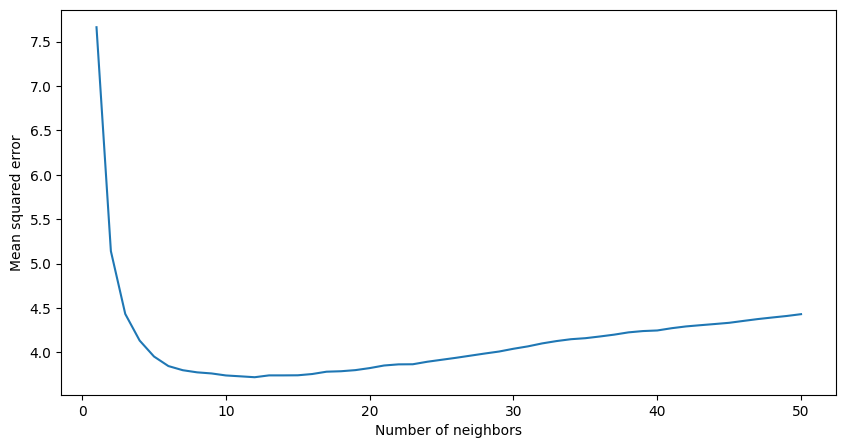

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

losses = []
min_loss = float('inf')
min_k = 0

for i in range(1, 51):
    pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor(n_neighbors=i))])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    loss = np.mean((y_pred - y_test)**2)
    if loss < min_loss:
        min_loss = loss
        min_k = i
    losses.append(loss)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 51), losses)
plt.xlabel('Number of neighbors')
plt.ylabel('Mean squared error')
plt.show()

In [33]:
print('Best k:', min_k)
print('Minimum loss:', min_loss)

Best k: 12
Minimum loss: 3.7193193214106635


In [34]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=min_k))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('Training Set:')
print('MAE:', mean_absolute_error(y_train, y_train_pred))
print('MSE:', mean_squared_error(y_train, y_train_pred))
print('R2 score:', r2_score(y_train, y_train_pred))

print()

print('Test Set:')
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2 score:', r2_score(y_test, y_pred))

Training Set:
MAE: 1.3305611278279281
MSE: 3.063396207139938
R2 score: 0.9368824465556921

Test Set:
MAE: 1.4662794584656527
MSE: 3.7193193214106635
R2 score: 0.922302652263916


In [12]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X, y, cv=10, scoring='neg_mean_absolute_error')
print('Cross-validation mean absolute error:', -scores.mean())

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_data.py", line 878, in fit
    return self.partial_fit(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_data.py", line 914, in partial_fit
    X = self._validate_data(
        ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 633, in _validate_data
    out = check_array(X, input_name="X", **check_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 929, in check_array
    array = array.astype(new_dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\generic.py", line 6643, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\internals\managers.py", line 430, in astype
    return self.apply(
           ^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\internals\managers.py", line 363, in apply
    applied = getattr(b, f)(**kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\internals\blocks.py", line 758, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\astype.py", line 237, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\astype.py", line 182, in astype_array
    values = _astype_nansafe(values, dtype, copy=copy)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\astype.py", line 133, in _astype_nansafe
    return arr.astype(dtype, copy=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Brazil'

--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_data.py", line 878, in fit
    return self.partial_fit(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_data.py", line 914, in partial_fit
    X = self._validate_data(
        ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 633, in _validate_data
    out = check_array(X, input_name="X", **check_params)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 929, in check_array
    array = array.astype(new_dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\generic.py", line 6643, in astype
    new_data = self._mgr.astype(dtype=dtype, copy=copy, errors=errors)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\internals\managers.py", line 430, in astype
    return self.apply(
           ^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\internals\managers.py", line 363, in apply
    applied = getattr(b, f)(**kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\internals\blocks.py", line 758, in astype
    new_values = astype_array_safe(values, dtype, copy=copy, errors=errors)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\astype.py", line 237, in astype_array_safe
    new_values = astype_array(values, dtype, copy=copy)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\astype.py", line 182, in astype_array
    values = _astype_nansafe(values, dtype, copy=copy)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\astype.py", line 133, in _astype_nansafe
    return arr.astype(dtype, copy=True)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Denmark'


In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# Định nghĩa số lượng folds cho cross-validation
cv = 10

# Sử dụng cross_val_score để tính toán R^2 score
r2_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores cho {cv}-fold cross-validation: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

# Sử dụng cross_val_score để tính toán MSE (sử dụng scoring 'neg_mean_squared_error')
mse_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
# Chuyển đổi MSE về giá trị dương
mse_scores = -mse_scores
print(f"MSE cho {cv}-fold cross-validation: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

# Đánh giá Mean Absolute Error (MAE)
mae_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE cho {cv}-fold cross-validation: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores cho 10-fold cross-validation: [ 0.65160199 -0.03351709  0.04809751 -1.70226055 -4.73875586 -6.90708052
 -5.82949607 -6.69995563 -6.24897201  0.35423423]
R^2 trung bình: -3.111 ± 3.079

MSE cho 10-fold cross-validation: [ 5.54197772  3.49846797 16.61081894  9.09227298  5.62777716  4.0524234
  3.25835655  4.82045708  7.66173356  7.59993868]
MSE trung bình: 6.776± 3.752

MAE cho 10-fold cross-validation: [1.93286908 1.43671309 3.38362117 2.49097493 1.93058496 1.61816156
 1.42122563 1.75919732 2.38467113 2.36828317]
MAE trung bình: 2.073 ± 0.570


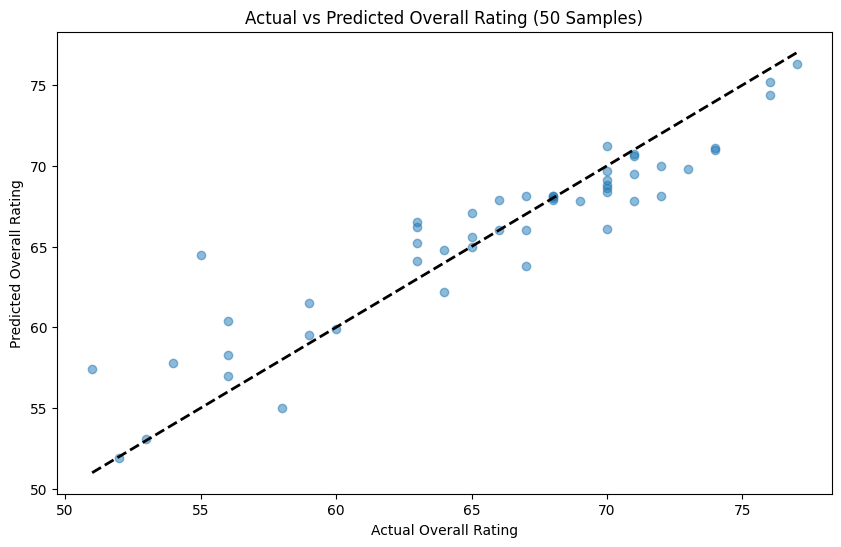

In [12]:
import matplotlib.pyplot as plt

# Select 20 samples
y_test_sample = y_test[:50]
y_pred_sample = y_pred[:50]

plt.figure(figsize=(10, 6))
plt.scatter(y_test_sample, y_pred_sample, alpha=0.5)
plt.plot([y_test_sample.min(), y_test_sample.max()], [y_test_sample.min(), y_test_sample.max()], 'k--', lw=2)
plt.xlabel('Actual Overall Rating')
plt.ylabel('Predicted Overall Rating')
plt.title('Actual vs Predicted Overall Rating (50 Samples)')
plt.show()